# Cup04: Unlearnable Dataset
110065508 李丞恩

In [1]:
INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE = 64 
EPOCHS = 10
PATIENCE = 10 # 如果過多少個EPOCHS沒改善就停止訓練
CATGORICAL = 2
LR = 0.001
LR_FACTOR = 0.5 # new_lr = lr * factor.
LR_PATIENCE = 4 # umber of epochs with no improvement after which learning rate will be reduced
MODEL_NAME = 'ResNet50_cup04'
MODEL_PATH = MODEL_NAME + '.hdf5'

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import re
import PIL
import time
import random
import string
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm.notebook import tqdm
from IPython import display

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import metrics, layers, Sequential, regularizers
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization, Input, Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler, scale
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, classification_report

2022-01-12 17:36:52.708445: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


2022-01-12 17:36:53.574588: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-01-12 17:36:53.629066: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-12 17:36:53.630346: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3060 computeCapability: 8.6
coreClock: 1.852GHz coreCount: 28 deviceMemorySize: 11.77GiB deviceMemoryBandwidth: 335.32GiB/s
2022-01-12 17:36:53.630394: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-01-12 17:36:53.634922: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-01-12 17:36:53.635005: I tensorflow/stream_executor/pl

## 一. 引入Dataset

In [4]:
x_train = np.load('./dataset/x_train_imagenet_unlearn.npy')
y_train = np.load('./dataset/y_train_imagenet.npy')
x_val = np.load('./dataset/x_val_imagenet.npy')
y_val = np.load('./dataset/y_val_imagenet.npy')
y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)

In [5]:
len(x_train)

2220

In [6]:
x_train[0].shape

(224, 224, 3)

In [7]:
len(np.unique(y_train))

2

In [8]:
len(x_val)

380

In [9]:
len(np.unique(y_val))

2

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
batched_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
batched_val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

2022-01-12 17:36:54.273099: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1336688640 exceeds 10% of free system memory.


2022-01-12 17:36:54.728808: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1336688640 exceeds 10% of free system memory.


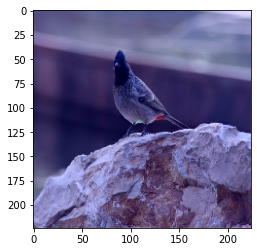

In [11]:
for data in batched_dataset.take(1):
    plt.imshow(data[0][3],cmap='gray')

## 二. 資料前處理

In [12]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(scale=1/255),
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=INPUT_SHAPE),
    layers.experimental.preprocessing.RandomContrast(factor = 0.5),
    layers.experimental.preprocessing.Normalization()
])

## 三. 模型搭建

In [13]:
model = Sequential([
    data_augmentation,
    ResNet50(include_top=False, weights=None, input_tensor=None, input_shape=INPUT_SHAPE), 
    Flatten(),
    Dropout(0.5),
    Dense(CATGORICAL, activation='softmax', name='softmax')
],
    name=MODEL_NAME
)
model.build((None, INPUT_SHAPE[0], INPUT_SHAPE[1], INPUT_SHAPE[2]))
model.summary()

Model: "ResNet50_cup04"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       7         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dropout (Dropout)            (None, 100352)            0         
_________________________________________________________________
softmax (Dense)              (None, 2)                 200706    
Total params: 23,788,425
Trainable params: 23,735,298
Non-trainable params: 53,127
_________________________________________________________________


In [14]:
loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.optimizers.Adam(learning_rate=LR)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['acc'])

## 四. 模型訓練

In [15]:
checkpoint = ModelCheckpoint(filepath=MODEL_PATH, 
                             monitor='val_acc',
                             verbose=1, 
                             save_best_only=True, 
                             mode='auto', 
                             save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_acc', 
                                   factor=LR_FACTOR, 
                                   patience=LR_PATIENCE, 
                                   verbose=1, 
                                   mode='auto', 
                                   min_delta=0.0001)
early = EarlyStopping(monitor='val_acc', 
                      mode="auto", 
                      patience=PATIENCE)
callbacks_list = [checkpoint, reduceLROnPlat, early]

In [16]:
start = datetime.datetime.now()
history = model.fit(x=batched_dataset, 
                    validation_data=batched_val_dataset, 
                    epochs=EPOCHS,
                    callbacks=callbacks_list,
                    verbose=1)
end = datetime.datetime.now()
CNN_time = end - start

2022-01-12 17:36:56.291194: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1336688640 exceeds 10% of free system memory.
2022-01-12 17:36:56.915482: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1336688640 exceeds 10% of free system memory.


Epoch 1/10


/home/benny/anaconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:4929: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(
2022-01-12 17:36:59.284203: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-12 17:36:59.320793: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2592000000 Hz
2022-01-12 17:37:00.021179: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-01-12 17:37:00.613697: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100
2022-01-12 17:37:01.479826: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-01-12 17:37

34/34 [==============================] - 21s 430ms/step - loss: 4.6169 - acc: 0.6425 - val_loss: 0.6915 - val_acc: 0.5938

Epoch 00001: val_acc improved from -inf to 0.59375, saving model to ResNet50_cup04.hdf5


2022-01-12 17:37:18.856364: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1336688640 exceeds 10% of free system memory.


Epoch 2/10
34/34 [==============================] - 14s 412ms/step - loss: 0.9462 - acc: 0.8943 - val_loss: 0.8467 - val_acc: 0.4062

Epoch 00002: val_acc did not improve from 0.59375
Epoch 3/10
34/34 [==============================] - 14s 413ms/step - loss: 1.7405 - acc: 0.8934 - val_loss: 3427.9204 - val_acc: 0.5938

Epoch 00003: val_acc did not improve from 0.59375
Epoch 4/10
34/34 [==============================] - 14s 413ms/step - loss: 1.0007 - acc: 0.8902 - val_loss: 1559.5433 - val_acc: 0.5938

Epoch 00004: val_acc did not improve from 0.59375
Epoch 5/10
34/34 [==============================] - 14s 417ms/step - loss: 0.5335 - acc: 0.9246 - val_loss: 12.5127 - val_acc: 0.5938

Epoch 00005: val_acc did not improve from 0.59375

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/10
34/34 [==============================] - 14s 416ms/step - loss: 2.7308 - acc: 0.9081 - val_loss: 2.8497 - val_acc: 0.5938

Epoch 00006: val_acc did not improve from 

## 五. 繪製結果

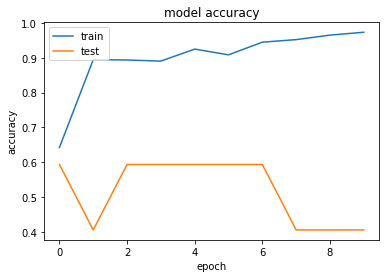

In [17]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
epoch = len(history.history['acc'])
train_acc = np.max(history.history['acc'])
val_acc = np.max(history.history['val_acc'])

In [21]:
localtime = time.strftime("%Y-%m-%d %I:%M:%S %p", time.localtime())
with open('./result.txt',  'a') as file_obj:
    file_obj.write('================RUN TIME: '+ localtime+ '================' + '\n')
    file_obj.write('model_name: '    + str(MODEL_NAME)        + '\n')
    file_obj.write('epoch: '         + str(epoch)             + '\n')
    file_obj.write('training time: ' + str(CNN_time)          + '\n')
    file_obj.write('train_acc: '     + str(train_acc)     + '\n')
    file_obj.write('val_acc: '       + str(val_acc)       + '\n')

## 六. 繳交

In [23]:
model.load_weights(MODEL_PATH)

In [25]:
x_test = np.load('./dataset/x_test_imagenet.npy')

In [51]:
y_test = np.argmax(model.predict(x_test, batch_size=BATCH_SIZE, verbose=1), axis=1).tolist()

2/2 [==============================] - 0s 108ms/step


Make submit file

In [58]:
id_csv = [i for i in range(len(y_test))]
df = pd.DataFrame(list(zip(id_csv,y_test)), columns = ['id','label'])
df.to_csv('cup04_group2.csv', index=False)